# Task2
## High Level State Representation
- Data is generated by an "expert" player.
- $timeout -sHUP 30m python ./lunar_lander_data_gen.py
    - generates data for 10 minutes
    - saves high level state representation as state_vectors_*.csv
    - saves image files in ./frames/2018-*/frame_2018_*.jpeg
- Train and evaluate a number of supervised machine learning models to predict actions of an "expert" player based off high level state representations


- Model saved as:
    - ml_images_player.mod
    

- Process: CRISP-DM
    - Iterating over this workflow
    - Assessing data, modeling, evaluating, re-developing
    - e.g. Strong accuracies, but poor flight from imbalanced dataset 
            -> undersampling
    - e.g. Initial learning curves implied immature models 
            -> generate more data.
    

## Nueral Net Overview:

All Nueral Nets are capable of capturing highly non-linear patterns (provided they allow use non-linear activation functions). This allows them to capture complex relationship and understand varieties of representations of data. These models tend to have a lot of freedom and can easily be overtrained. Adding some constraints to these models (removing some freedom) can lead to better, faster, more compact learners making them more practical.

Nueral Nets can be considered as layers of nodes. There is an input layer (which recieve input data, and output layer which outputs the data from the model, perhaps a class_label. Between the input and output layers there are hidden layes which recieve inputs from a previous layer and provide an output to a subsequent layer within the model.

Nodes in each layer have a forward connection to nodes in the subsequent layer. Connections can be dense, where nodes have many connections to subsequent layer. In contrast, nodes that have relatively few connections to the subsequent layer have sparse connectivity.

Nodes have activation functions to transform their input. Similarly connections have weights, which allows for subsequent nodes to favor inputs from some nodes more than others. Models are trained by altering these wait through back propagation, to optimise some defined loss function.


## Reset Colaboratory

In [0]:
!kill -9 -1

## Check GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name



'/device:GPU:0'

## Install Keras and Imblearn

In [0]:
!pip install -q keras
!pip install -q imbalanced-learn

## Upload Local Files

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print(fn, 'uploaded')

Saving my_lib.py to my_lib (1).py
Saving rus_data.zip to rus_data (1).zip
my_lib.py uploaded
rus_data.zip uploaded


In [1]:
#!unzip -q rus_data.zip
!ls


datalab  my_lib.py  __pycache__  rus_data  rus_data.zip


## Imports

In [1]:
import os 
import cv2
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import  GridSearchCV, StratifiedKFold, \
                                     cross_val_score
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import shuffle

import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, adam
from keras.utils import np_utils, plot_model

from my_lib import topn, plot_learning_curve

from keras import backend as K
K.set_image_data_format('channels_first')

Using TensorFlow backend.


## Plug In Data

In [0]:

#Other user
#TRAIN_DIR = './frames/something..etc/'

#Andy
#TRAIN_DIR = './frames/2018-04-21-20-41-25/'

#Colaboratory
TRAIN_DIR = './rus_data/'

#Conor
#TRAIN_DIR = '../frames/2018-04-20-15-12-38/'


## Upload Size
A few bash commands were used to gather more data and under sample it locally. This was uploaded with a zip file. This allows for the majority of the uploaded data to be used rather than discarded, saving network ovehead and giving better memory utilisation in colaboratory.

In [4]:
len(os.listdir(TRAIN_DIR))

37229

## Experiment Parameters

In [0]:
sample_rate = 1
ROWS = 64
COLS = 64
CHANNELS = 1

#Stratify to preserve label weightings
grid_search_cv_folds = StratifiedKFold(3, shuffle=True) #keep this small
cv_experiment_folds = StratifiedKFold(5, shuffle=True)  #better to keep this a bit bigger. 8 or 10
learning_curve_folds = StratifiedKFold(3, shuffle=True) #keep this small

## Prepare Dataset
- Convert images into greyscale
- Shrinking Images; flattened 64x64 array 
- Normalising Image Data; 
- Undersampling data
- Storing in np.ndarray for efficiency (less overhead that pd.DataFrame), and typing is uniform.
- Sampling data for efficiency

In [5]:
# generate filenames from the data folder and do sampling
def sample_files(train_dir):
    image_filenames = [train_dir+i for i in os.listdir(train_dir) if not i.startswith('.')] # use this for full dataset
    sample_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))
    return sample_filenames

sample_filenames = sample_files(TRAIN_DIR)

# Init a data array for image data
count = len(sample_filenames)
X = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.float)

# Iterate throuigh the filenames and for each one load the image, resize and normalise
for i, image_file in enumerate(sample_filenames):
    image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)        
    X[i] = image
    X[i] = X[i]/255
    if i%10000 == 0: print('Processed {} of {}'.format(i, count))

print("Train shape: {}".format(X.shape))

Processed 0 of 37229
Processed 10000 of 37229
Processed 20000 of 37229
Processed 30000 of 37229
Train shape: (37229, 1, 64, 64)


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


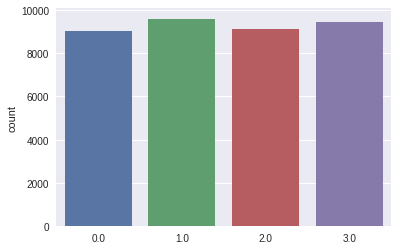

In [6]:
# Extract the lables from the last characters in the filename
y = np.empty(count)
for idx, i in enumerate(sample_filenames):
    l = i[-6:-5]
    y[idx] = l
        
# Count the number of clases
num_classes = len(set(y))

# convert to binary encoded labels
labels_wide = keras.utils.to_categorical(y, num_classes)

# Plot a bar plot of the 
sns.countplot(y)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


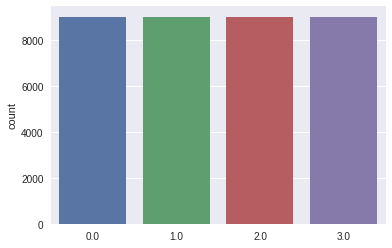

In [7]:
rus = RandomUnderSampler(return_indices=True)
# Neat Trick : -1 infers missing argument in reshape
X, y, idx_resampled = rus.fit_sample(X.reshape(-1, ROWS*COLS*CHANNELS), y)
X, y = shuffle(X, y)
X = X.reshape(-1, CHANNELS,ROWS,COLS)
sns.countplot(y)
y_wide = keras.utils.to_categorical(y, num_classes)


0.0


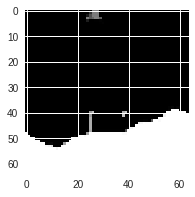

0.0


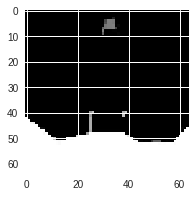

3.0


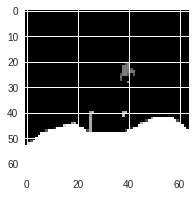

2.0


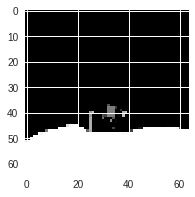

3.0


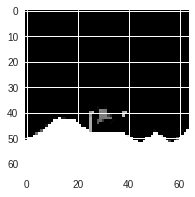

In [8]:
#show some screens
for i in range(0,5):
    idx = random.randint(0, len(y))
    print(y[idx])
    plt.figure(figsize=(3,3))
    plt.imshow(X[idx][0], cmap='gray')
    plt.show()

In [0]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2, train_size = 0.8)
y_train_wide = keras.utils.to_categorical(y_train, num_classes)
y_test_wide =  keras.utils.to_categorical(y_test, num_classes)

# Define Keras Models

In this task we build, test, tune and evaluate several different model architectures.

- SingleLayerPerceptron
    - Input -> output
    - no hidden layers


- MultiLayerPerceptron
    - Input -> hidden -> output
    - single hidden layer


- Deep Feed Forward Nueral Network
    - Input -> hidden -> hidden -> ... -> output
    - multiple hidden layers


- Convolutional Nueral Network CNN
    - Input -> Convolutions & Pooling -> ... -> Flat Densly Connected -> softmax output
    - Generally accepted as the most suitable architecture for image classification.
    - Should identify Lander and the direction in which it projects fuel.
    - Uses shared weights:
        - Provides Translation Invariance: (Convinient Property)
            - All nodes in a layer share a weight-vector/filter for their inbound connections.
            - An object may occur at different positions in the dataset.
            - But it is still handled in the same way by the filters.
        - Reduces freedom in the model (faster training, and less overfitting.)
            - The model trains these shared weights.
        - Lower memory requirements, faster training and predictions.
    - Sparse Connections:
        - Makes back propagation easier.
        - Focuses on local connections; receptive field.
        - Reduces overfitting
    - Pooling:
        - Aggregates the output of a filter.
        - Reduces dimensionality within network.
        - Model is more compact, faster training and predictions.
    - These method allow the model to go deeper with less drawbacks.


In [0]:
flat_shape =  (CHANNELS*ROWS*COLS,)
image_shape = (CHANNELS, ROWS, COLS,)


def SLP(lr=1e-3):
    model = Sequential()
    model.add(Dense(num_classes, input_shape=flat_shape, use_bias=False, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=lr), metrics=['accuracy'])
    return model

def MLP(lr=1e-3):
    model = Sequential()
    model.add(Dense(64, input_shape=flat_shape, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=lr), metrics=['accuracy'])
    return model
              

def DFFNN(dropout_rate=0.0, lr=1e-3):
    model = Sequential()
    model.add(Dense(64, input_shape=flat_shape, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=lr), metrics=['accuracy'])
    return model


def CNN(dropout_rate=0.0, lr=1e-3):
    model = Sequential()
    model.add(Conv2D(16, (8, 8), padding='same', input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Conv2D(8, (4, 4), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=adam(lr=lr), metrics=['accuracy'])
    return model


The model architectures were alightly adjusted throughout testing. The CNN to improve train time an accuracy. This included changing pooling dimensions form 2,2 to 8,8 to reduce train times by aggregating. Similarly increasing the number (and dimensions) of filters and hidden layer size. These changes had minimal effect, the more significant effects came from adding more data and adjusting dropout rate and epochs. It is however believed that these features of the model would be of greater importance once the needs for data are fulfilled.

## Search Space

In [0]:

# list all build architectures to be explored
clfs = [SLP, MLP, DFFNN, CNN]
input_shapes = {
    'SLP':flat_shape,
    'MLP':flat_shape,
    'DFFNN':flat_shape,
    'CNN':image_shape
}

model_params = set(['dropout_rate','lr'])
fit_params = set(['epochs', 'batch_size', 'validation_split','shuffle'])

param_grids= {
    'SLP': {
        "epochs":list(range(45,51,10)),   
        "batch_size":[512], #powers of 2
        "validation_split":[0.2],
        "shuffle":[True],
        "lr":[1e-3,]
    },
    'MLP': {
        "epochs":list(range(45,51,10)),   
        "batch_size":[512,], #powers of 2
        "validation_split":[0.2],
        "shuffle":[True],
        "lr":[1e-3,]
    },
    'DFFNN' : {
        "epochs":list(range(30,35,10)),   
        "batch_size":[512], #powers of 2
        "validation_split":[0.2],
        "shuffle":[True],
        'dropout_rate':[0.4],
        "lr":[1e-3,]
    },
    'CNN' : {
        "epochs":list(range(30,35,10)),   
        "batch_size":[512], #powers of 2
        "validation_split":[0.2],
        "shuffle":[True],
        'dropout_rate':[0.4],
        "lr":[1e-3,]
    }
}


## Execute Search

Collaboratory times out every 45 minutes, gridsearches can't be extensive. Gridsearch was run in phases and repeatedly evaluated. For each classifier 
lr was tested from 0.001 - 0.01, epochs from 5, 50, batches 128 -1024, and validation from 0.05 - 0.25. Classifiers grew in strength from 30%-60%+, 70%+. Epoch is responsible for run times.
A limiting factor is the amount of data the model recienves. It's learning was greatly amplified as data was scaled up, this can be seen in the learning curves below.

In [13]:
%%time
# store the best params and scores for each classifier
stored_grid_searches={}

# running grid search for each classifier
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = input_shapes[clf_name]
    current_GS = GridSearchCV(KerasClassifier(build_fn=clf, verbose=0), 
                              param_grids[clf_name],
                              cv=grid_search_cv_folds,
                              verbose=1,
                              refit=True,
                              #n_jobs=-1,
                              return_train_score=True).fit(
        X_train.reshape(-1, *input_shape), y_train)
    
    # store grid search object for each classifier
    stored_grid_searches[clf_name] = current_GS

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


CPU times: user 6min 31s, sys: 1min 42s, total: 8min 14s
Wall time: 8min 32s


### Inspect Search Results

- GridSearch results are double checked
- Models are considered on train/prediction times and accuracy.
- In each case, the best params were judged to be those identified by the grid search.

In [0]:
#store selcted params for each classifier
selected_params={}
    

In [15]:
#print top10 results
SLP_GS = stored_grid_searches['SLP']
topn(SLP_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_epochs,param_lr,param_shuffle,param_validation_split,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,21.163,0.17,0.68,0.704,512,45,0.001,True,0.2,"{'batch_size': 512, 'epochs': 45, 'lr': 0.001,...",...,0.677,0.704,0.679,0.708,0.684,0.699,1.139,0.002,0.003,0.004


In [16]:
print("best params:", SLP_GS.best_params_)
print("best score:", SLP_GS.best_score_)

#store best random forest
selected_params['SLP'] = SLP_GS.best_params_

best params: {'batch_size': 512, 'epochs': 45, 'lr': 0.001, 'shuffle': True, 'validation_split': 0.2}
best score: 0.6799806176163756


In [17]:
#print top10 results
MLP_GS = stored_grid_searches['MLP']
topn(MLP_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_epochs,param_lr,param_shuffle,param_validation_split,params,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,21.652,0.174,0.71,0.739,512,45,0.001,True,0.2,"{'batch_size': 512, 'epochs': 45, 'lr': 0.001,...",...,0.706,0.743,0.706,0.729,0.717,0.744,0.265,0.003,0.005,0.007


In [18]:
print("best params:", SLP_GS.best_params_)
print("best score:", SLP_GS.best_score_)

#store best random forest
selected_params['MLP'] = MLP_GS.best_params_

best params: {'batch_size': 512, 'epochs': 45, 'lr': 0.001, 'shuffle': True, 'validation_split': 0.2}
best score: 0.6799806176163756


In [19]:
#print top10 results
DFFNN_GS = stored_grid_searches['DFFNN']
topn(DFFNN_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_dropout_rate,param_epochs,param_lr,param_shuffle,param_validation_split,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,16.981,0.167,0.532,0.544,512,0.4,30,0.001,True,0.2,...,0.597,0.616,0.502,0.507,0.498,0.51,0.29,0.007,0.046,0.051


In [20]:
print("best params:", DFFNN_GS.best_params_)
print("best score:", DFFNN_GS.best_score_)

#store best random forest
selected_params['DFFNN'] = DFFNN_GS.best_params_

best params: {'batch_size': 512, 'dropout_rate': 0.4, 'epochs': 30, 'lr': 0.001, 'shuffle': True, 'validation_split': 0.2}
best score: 0.5321196186506202


In [21]:
#print top10 results
CNN_GS = stored_grid_searches['DFFNN']
topn(DFFNN_GS, 10).round(3)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_batch_size,param_dropout_rate,param_epochs,param_lr,param_shuffle,param_validation_split,...,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,16.981,0.167,0.532,0.544,512,0.4,30,0.001,True,0.2,...,0.597,0.616,0.502,0.507,0.498,0.51,0.29,0.007,0.046,0.051


In [22]:
print("best params:", CNN_GS.best_params_)
print("best score:", CNN_GS.best_score_)

#store best random forest
selected_params['CNN'] = CNN_GS.best_params_

best params: {'batch_size': 512, 'dropout_rate': 0.4, 'epochs': 30, 'lr': 0.001, 'shuffle': True, 'validation_split': 0.2}
best score: 0.5321196186506202


## Selected Params and Models
Unexpectedly, SLP and MLP are the stronger learners. Its expected that with more data DFFNN and CNN would be more robust learners, they just need more data to activate this potential. Uploading more data is unfeasable without introducing an iterative training methodology to load portions of data into memory for training. Due to time constraints this option was not developed.

## Chosen Params from Entire Search
As Colaboratory can often timeout or lose it's runtime, it can be useful to save intermediate results like this to save gridsearching.

In [0]:
clfs = [SLP, MLP]
selected_params = {
    'SLP': {
        "epochs":45,   
        "batch_size":512, #powers of 2
        "validation_split":0.2,
        "shuffle":True,
        "lr":1e-3
    },
    'MLP': {
        "epochs":45,   
        "batch_size":512, #powers of 2
        "validation_split":0.2,
        "shuffle":True,
        "lr":1e-3
    },
    'DFFNN' : {
        "epochs":30,   
        "batch_size":512, #powers of 2
        "validation_split":0.2,
        "shuffle":True,
        'dropout_rate':0.4,
        "lr":1e-3
    },
    'CNN' : {
        "epochs":30,   
        "batch_size":512, #powers of 2
        "validation_split":0.2,
        "shuffle":True,
        'dropout_rate':0.4,
        "lr":1e-3
    }
}


## 5xCV Experiment : Train Set
The scores produced are similar to those obtained from the Gridsearch, so tuned models are relatively robust thus far. 10XCV was a bit too expensive, so it was reduced to five. With more accessable resources this would be scaled to 10xCV as it is more robust and an accepted standard.

In [14]:
%%time
# 10xCV on sample data using selected params
cv_scores = {}
for clf in clfs:
    clf_name = str(clf).split()[1]
    input_shape = input_shapes[clf_name]
    params = selected_params[clf_name]
    cv_scores[clf_name] = np.mean(cross_val_score(KerasClassifier(build_fn=clf,**params, verbose=0),
                                                  X_train.reshape(-1, *input_shape), 
                                                  y_train, cv=cv_experiment_folds,
                                                 )
                                 ) 



CPU times: user 4min 15s, sys: 33.3 s, total: 4min 49s
Wall time: 4min 11s


In [15]:
# print the avg CVx10 score.
pd.DataFrame(cv_scores, [0]).round(3)

,MLP,SLP
0,0.705,0.696


## Learning Curves : Train Set
#### === THIS WILL TAKE A WHILE ===

The curves here are similar in shape to the MLP produced in task one, however the difference between train set and validation set is larger. The training score shows a clear bias in both cases, each model could benefit from more data as there is still a reasonable upward trend. It is believed that the larger epoch sizes are responsible for the bias in the train scores produced. The epochs did increase the validation scores, helping the model generalise, however it does start to overfit to the train data.

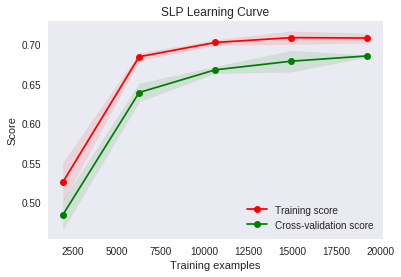

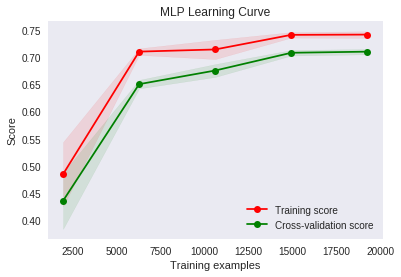

In [16]:
# Print learning curves for each model
steps = 5
for clf in clfs:
    clf_name = str(clf).split()[1]
    params = selected_params[clf_name]
    input_shape = input_shapes[clf_name]
    plot_learning_curve(KerasClassifier(build_fn=clf,**params, verbose=0), 
                        clf_name+' Learning Curve', 
                        X_train.reshape(-1, *input_shape),
                        y_train, 
                        cv=learning_curve_folds,
                        train_sizes=np.linspace(.1,1.0, steps))


# Holdout Experiment
Both models tend to score better on the holdout set (this is likely an "unfortunate" split, as a 5xCV score is more robust. This is a good sign, as models performed acceptably. The loss curves illustrate that ass epochs increase past 10, the training and validation curves diverge significantly, showing that many epochs can cause a bias to training data. A method to reduce this bias is more data with mini batches.

In [17]:
%%time

# Fit best models
fitted_models = {}
for clf in clfs:
    clf_name = str(clf).split()[1]
    all_params = selected_params[clf_name]
    modelling_params = {k:v for k,v in all_params.items() if k in model_params}
    fitting_params = {k:v for k,v in all_params.items() if k in fit_params}
    input_shape = input_shapes[clf_name]
    
    model = clf(**modelling_params)
    history = model.fit(X_train.reshape(-1, *input_shape), 
                        y_train_wide, 
                        **fitting_params,
                        verbose=0)
    
    fitted_models[clf_name] = [model, history]


CPU times: user 1min 3s, sys: 7.57 s, total: 1min 11s
Wall time: 1min 1s


****** Test Data ********
SLP
Report:
              precision    recall  f1-score   support

        0.0       0.74      0.60      0.66      1850
        1.0       0.76      0.78      0.77      1748
        2.0       0.60      0.75      0.67      1759
        3.0       0.80      0.74      0.77      1867

avg / total       0.72      0.71      0.71      7224

Confusion Matrix
 [[1102  106  528  114]
 [ 104 1360  171  113]
 [ 170  145 1322  122]
 [ 113  188  190 1376]]
Accuracy: 0.7142857142857143


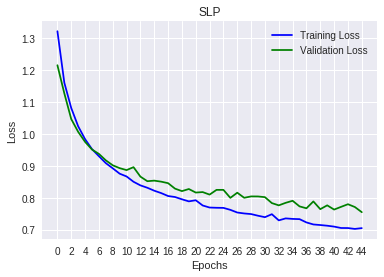

MLP
Report:
              precision    recall  f1-score   support

        0.0       0.86      0.56      0.68      1850
        1.0       0.83      0.74      0.78      1748
        2.0       0.60      0.86      0.71      1759
        3.0       0.78      0.80      0.79      1867

avg / total       0.77      0.74      0.74      7224

Confusion Matrix
 [[1036   82  604  128]
 [  53 1299  204  192]
 [  55   84 1521   99]
 [  54  109  203 1501]]
Accuracy: 0.7415559246954596


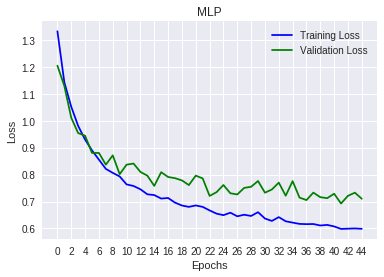

,MLP,SLP
0,0.742,0.714


In [18]:
#Evaluate with Test dataset

print("****** Test Data ********")

holdout_scores ={}
for clf_name, clf_data in fitted_models.items():
    model, history = clf_data
    input_shape = input_shapes[clf_name]
    pred = model.predict(X_test.reshape(-1, *input_shape))
    
    #Decode from 1Hot -> multiclass
    pred = pred.argmax(axis=1)

    #store holdout scores
    holdout_scores[clf_name] = metrics.accuracy_score(y_test, pred)
    
    # Print performance overview
    print(clf_name)
    print('Report:\n',metrics.classification_report(y_test, pred))
    print("Confusion Matrix\n", metrics.confusion_matrix(y_test, pred))

    #Accuracy
    print('Accuracy:',metrics.accuracy_score(y_test, pred))
    print('='*100)

    #plot loss curves
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.title(clf_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss, 'blue', label='Training Loss')
    plt.plot(val_loss, 'green', label='Validation Loss')
    plt.xticks(range(0,params['epochs'])[0::2])
    plt.legend()
    plt.show()
    
pd.DataFrame(holdout_scores, [0]).round(3)

### MLP
The MLP is a clear victor, it has a noteicably stronger performance on holdout and cross validation. With a score or 70+. From testing this model in the simulator, its prone to crashing but tends to score close to 0. THe confusion matrices produced show similar trends to those of the state players. The most noticable error is firing the main engine in a situation where the model should do nothing. If particles have residue on the picture, it could be that the model does not have the resulution to understand what "doing nothing" looks like. Similarly subtle corrections with a stabliser may be hard to notice, and could be mistake for "doing nothing".

In [20]:
#Pick best model
the_best = 'MLP'
filepath = "ml_images_player.mod"

#retrieve model and associated data
input_shape = input_shapes[the_best]
model, history = fitted_models[the_best]

#verify its working
model.predict(X_test.reshape(-1, *input_shape))

#save model
model.save(filepath)

#load a model
model = keras.models.load_model("ml_images_player.mod")

#verify its working
model.predict(X_test.reshape(-1, *input_shape))
#Remember Class_label <- np.argmax(predictions)

#summary
model.summary()




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 64)                262208    
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 260       
Total params: 262,468
Trainable params: 262,468
Non-trainable params: 0
_________________________________________________________________


In [0]:
from google.colab import files

files.download(filepath)